<a href="https://colab.research.google.com/github/Volandum/AoE2-data/blob/main/AOE2_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download and analysis of AOE2 data from the AOE2.net API: https://aoe2.net/#api

First we'll need to download and save the data.

In [ ]:
# Parameters for download

import time # Functions for handling epochs and making datetimes readable
from json import loads # Parse imported data
from requests import get # Download URLs to use the API
import pickle # For saving out data

#starting_epoch = int(time.mktime(time.strptime('2022-5-19 UTC','%Y-%m-%d %Z')) - 20000) # Use time.strptime('2020-8-7 UTC','%Y-%m-%d %Z') for user-readable datetimes, time.gmtime() is now.
print('Starting epoch:'); print(time.gmtime(starting_epoch))
matches_per_batch = 1000 # Max 1000
max_downloads = 10000
#end_epoch = int(time.mktime(time.gmtime())) # Stop either when max_downloads hit or end_epoch hit or no more games

Starting epoch:


NameError: ignored

In [ ]:
# Helper functions for match data download

def get_matches_list(count, epoch_from):
  url = 'https://aoe2.net/api/matches?game=aoe2de&count=' + str(count) + '&since=' + str(epoch_from)
  # Strings which need to be eval_able
  return(loads(get(url).text))

# The list comprehensions get expensive for large (multi-day) downloads, stagger into downloading and saving out individual days into pickles
def get_matches(count, start_epoch, max_downloads, end_epoch):
  current_epoch = start_epoch
  matches_so_far = []
  match_ids_so_far = []
  for download_index in range(max_downloads):
    downloaded_list = get_matches_list(count, current_epoch)
    downloaded_match_ids = [match['match_id'] for match in downloaded_list]
    new_match_ids = [match_id for match_id in downloaded_match_ids if match_id not in match_ids_so_far]
    if len(new_match_ids) == 0:
      break
    new_matches = [downloaded_list[i] for i, match_id in enumerate(downloaded_match_ids) if match_id in new_match_ids]
    current_epoch = max([match['opened'] for match in new_matches])
    if current_epoch > end_epoch:
      break # Note some matches may go past the end_epoch here
    matches_so_far = matches_so_far + new_matches
    match_ids_so_far = match_ids_so_far + new_match_ids
  matches_to_return = [match for match in matches_so_far if match['opened'] <= end_epoch]
  return matches_to_return

def get_matches_for_ranges(epoch_range, count, max_downloads):
  # Each epoch range is (start_epoch, end_epoch)
  gotten_matches = get_matches(count, epoch_range[0], max_downloads, epoch_range[1])
  filename = 'downloaded_raw_' + str(epoch_range[0]) + '_' + str(epoch_range[1]) + '.pkl'
  with open(filename, 'wb') as outp:  # Overwrites any existing file.
    pickle.dump(gotten_matches, outp, pickle.HIGHEST_PROTOCOL)
    print(filename)
  return(filename)

In [ ]:
# Get data from 2022-5-19 <= date < 2022-5-26 (1 week of data):
# Using https://stackoverflow.com/a/23190286/11732165
# Do another batch 2022-5-26 up to and not including 2022-6-3 
import pandas as pd 

date_range_to_collect = date_range(start="2022-5-26",end="2022-6-3")
epoch_points = list((date_range_to_collect - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s"))
epoch_ranges = [(epoch_points[i], epoch_points[i+1] - 1) for i in range(len(epoch_points) - 1)]
filenames = [get_matches_for_ranges(epoch_range, matches_per_batch, max_downloads) for epoch_range in epoch_ranges]

downloaded_raw_1653523200_1653609599.pkl
downloaded_raw_1653609600_1653695999.pkl
downloaded_raw_1653696000_1653782399.pkl
downloaded_raw_1653782400_1653868799.pkl
downloaded_raw_1653868800_1653955199.pkl
downloaded_raw_1653955200_1654041599.pkl
downloaded_raw_1654041600_1654127999.pkl
downloaded_raw_1654128000_1654214399.pkl


In [ ]:
# Collate the data and save this out for now
#match_list = []

for filename in filenames:
  with open(filename, 'rb') as inp:
    match_list = match_list + pickle.load(inp)

with open('temp_raw_data.pkl', 'wb') as outp:
    pickle.dump(match_list, outp, pickle.HIGHEST_PROTOCOL)



In [ ]:
# https://stackoverflow.com/a/57983757/11732165 suggests compressing the pickle file - it's much slower (3 mins for a week of data) but less unwieldy (16M vs 331M)

import lzma
with lzma.open("compressed_raw_data.xz", "wb") as f:
    pickle.dump(match_list, f, pickle.HIGHEST_PROTOCOL)


In [ ]:
# Load from pickle

with open('temp_raw_data.pkl', 'rb') as inp:
    match_list = pickle.load(inp)


In [ ]:
# Load from compressed pickle is pretty fast

with lzma.open("compressed_raw_data.xz", "rb") as f:
    match_list = pickle.load(f)


In [ ]:
# Load requisites for conversion to dataframe
import pandas as pd
import numpy as np

In [ ]:
# Convert to a dataframe
# We care about the fields:
# match_id, match_uuid, num_players, name, ranked, started, finished
def get_rating_range(players, want_min = True):
  ratings = [player['rating'] for player in players]
  ratings = [rating for rating in ratings if rating is not None]
  if len(ratings) == 0:
    return None
  if want_min:
    return(min(ratings))
  else:
    return(max(ratings))


match_dataframe = \
  pd.DataFrame({'match_id': [match['match_id'] for match in match_list], 
                'match_uuid': [match['match_uuid'] for match in match_list],
                'num_players': [match['num_players'] for match in match_list],
                'name': [match['name'] for match in match_list],
                'ranked': [match['ranked'] for match in match_list],
                'started': [match['started'] for match in match_list],
                'finished': [match['finished'] for match in match_list],
                'min_rating': [get_rating_range(match['players'], True) for match in match_list],
                'max_rating': [get_rating_range(match['players'], False) for match in match_list],
                'p1_civ': [match['players'][0]['civ'] for match in match_list],
                'plast_civ': [match['players'][-1]['civ'] for match in match_list],
                'p1_rating': [match['players'][0]['rating'] for match in match_list],
                'plast_rating': [match['players'][-1]['rating'] for match in match_list],
                'p1_won': [match['players'][0]['won'] for match in match_list],
                'plast_won': [match['players'][-1]['won'] for match in match_list]
                })


In [ ]:
restricted_match_dataframe = match_dataframe[(match_dataframe['name'] == 'AUTOMATCH') & (match_dataframe['num_players'] == 2) & 
                                             (match_dataframe['p1_rating'] >= 1200) & (match_dataframe['plast_rating'] >= 1200)].copy()
restricted_match_dataframe['duration'] = restricted_match_dataframe['finished'] - restricted_match_dataframe['started']

In [ ]:
# Reduce data to specific matchups and complete duration data

further_restricted_df = restricted_match_dataframe[['duration', 'p1_civ', 'plast_civ', 'p1_rating', 'plast_rating', 'p1_won', 'plast_won']][restricted_match_dataframe['duration'].notnull()]
further_restricted_df['p1_won'] = np.where(further_restricted_df['p1_won'], 1, 0)
further_restricted_df['plast_won'] = np.where(further_restricted_df['plast_won'], 1, 0)
new_data_df = pd.DataFrame({
    'duration': further_restricted_df['duration'],
    'civ1': np.where(further_restricted_df['p1_civ'] <= further_restricted_df['plast_civ'], further_restricted_df['p1_civ'], further_restricted_df['plast_civ']),
    'civ2': np.where(further_restricted_df['p1_civ'] <= further_restricted_df['plast_civ'], further_restricted_df['plast_civ'], further_restricted_df['p1_civ']),
    'civ1_rating': np.where(further_restricted_df['p1_civ'] <= further_restricted_df['plast_civ'], further_restricted_df['p1_rating'], further_restricted_df['plast_rating']),
    'civ2_rating': np.where(further_restricted_df['p1_civ'] <= further_restricted_df['plast_civ'], further_restricted_df['plast_rating'], further_restricted_df['p1_rating']),
    'civ1_won': np.where(further_restricted_df['p1_civ'] <= further_restricted_df['plast_civ'], further_restricted_df['p1_won'], further_restricted_df['plast_won']),
    'civ2_won': np.where(further_restricted_df['p1_civ'] <= further_restricted_df['plast_civ'], further_restricted_df['plast_won'], further_restricted_df['p1_won']),
})

# Also data for if we just care about all non-mirror matchups for each faction
new_data_df_flipped = pd.DataFrame({'duration': new_data_df['duration'],
                                    'civ1': new_data_df['civ2'],
                                    'civ2': new_data_df['civ1'],
                                    'civ1_rating': new_data_df['civ2_rating'],
                                    'civ2_rating': new_data_df['civ1_rating'],
                                    'civ1_won': new_data_df['civ2_won'],
                                    'civ2_won': new_data_df['civ1_won']})

combined_data = pd.concat([new_data_df, new_data_df_flipped])
combined_data = combined_data[combined_data['civ1'] != combined_data['civ2']]

In [ ]:
# Get the civ lookup

aoe2_strings = loads(get('https://aoe2.net/api/strings?game=aoe2de&language=en').text)
civ_dataframe = pd.DataFrame({'civid': [string['id'] for string in aoe2_strings['civ']],
                              'civstring': [string['string'] for string in aoe2_strings['civ']]})

In [ ]:
single_civ_matchup_df = combined_data = combined_data[combined_data['civ1'] != combined_data['civ2']] \
                 .merge(civ_dataframe.rename(columns = {'civid': 'civ1', 'civstring': 'civ1_name'}), how = 'left')

In [ ]:
single_civ_match_count = single_civ_matchup_df.groupby(['civ1_name'])['duration'].count().reset_index(name="matches")
single_civ_outcome_counts = single_civ_matchup_df.groupby(['civ1_name', 'duration'], as_index=False)[['civ1_won', 'civ2_won']].sum().sort_values(['civ1_name', 'duration'])
single_civ_outcome_counts['civ1_won_total'] = single_civ_outcome_counts.groupby(['civ1_name'])['civ1_won'].cumsum()
single_civ_outcome_counts['civ2_won_total'] = single_civ_outcome_counts.groupby(['civ1_name'])['civ2_won'].cumsum()
single_civ_outcome_counts_with_totals = single_civ_outcome_counts.merge(single_civ_match_count)
single_civ_outcome_counts_with_totals['civ1_prop'] = single_civ_outcome_counts_with_totals['civ1_won_total'] / single_civ_outcome_counts_with_totals['matches']
single_civ_outcome_counts_with_totals['civ2_prop'] = single_civ_outcome_counts_with_totals['civ2_won_total'] / single_civ_outcome_counts_with_totals['matches']
single_civ_outcome_counts_with_totals['one_minus_civ2_prop'] = 1 - single_civ_outcome_counts_with_totals['civ2_prop']

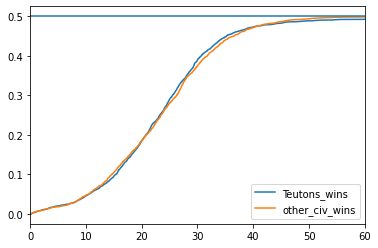

Out of 3674 games the Teutons won 1824 and lost 1836. Out of the concluded games the win rate was 49.8%.


In [ ]:
#@title Single civilisation vs any other civ (distribution as observed), 1v1 ranked only
# Using the Colab guide on interactive forms at https://colab.research.google.com/notebooks/forms.ipynb
civ_dataframe.civstring.unique()
civ_chosen = 'Teutons' #@param {type:"string"} ['Britons', 'Franks', 'Goths', 'Teutons', 'Japanese', 'Chinese','Byzantines', 'Persians', 'Saracens', 'Turks', 'Vikings','Mongols', 'Celts', 'Spanish', 'Aztecs', 'Mayans', 'Huns','Koreans', 'Italians', 'Hindustanis', 'Incas', 'Magyars', 'Slavs','Portuguese', 'Ethiopians', 'Malians', 'Berbers', 'Khmer', 'Malay','Burmese', 'Vietnamese', 'Bulgarians', 'Tatars', 'Cumans','Lithuanians', 'Burgundians', 'Sicilians', 'Poles', 'Bohemians','Dravidians', 'Bengalis', 'Gurjaras', 'Indians'] {allow-input: false}


plot_data = single_civ_outcome_counts_with_totals[single_civ_outcome_counts_with_totals['civ1_name'] == civ_chosen].copy()
plot_data['minutes'] = plot_data['duration'] / 60
import matplotlib.pyplot as plt
plt.plot(plot_data['minutes'], plot_data['civ1_prop'], label = civ_chosen + '_wins')
plt.plot(plot_data['minutes'], plot_data['civ2_prop'], label = 'other_civ_wins')
plt.axhline(y=0.5)
plt.xlim((0,60))
plt.legend()
plt.show()

print('Out of ' + str(plot_data.matches.max()) + ' games the ' + civ_chosen + 
      ' won ' + str(plot_data.civ1_won_total.max()) + ' and lost ' + str(plot_data.civ2_won_total.max()) + '. ' +
      'Out of the concluded games the win rate was ' + str((plot_data.civ1_won_total.max() / (plot_data.civ1_won_total.max() + plot_data.civ2_won_total.max()) * 1000) // 1 / 10) + '%.')


In [ ]:
civ_matchup_df = combined_data \
                 .merge(civ_dataframe.rename(columns = {'civid': 'civ1', 'civstring': 'civ1_name'}), how = 'left') \
                 .merge(civ_dataframe.rename(columns = {'civid': 'civ2', 'civstring': 'civ2_name'}), how = 'left')

In [ ]:
# Compute a K-M curve
further_restricted_df.head()

# We want to group by duration, count up p1_won and plast_won
# Then order by duration and calculate the cumsums
# Then we can plot
match_count = civ_matchup_df.groupby(['civ1_name','civ2_name'])['duration'].count().reset_index(name="matches")
outcome_counts = civ_matchup_df.groupby(['civ1_name', 'civ2_name', 'duration'], as_index=False)[['civ1_won', 'civ2_won']].sum().sort_values(['civ1_name', 'civ2_name', 'duration'])
outcome_counts['civ1_won_total'] = outcome_counts.groupby(['civ1_name', 'civ2_name'])['civ1_won'].cumsum()
outcome_counts['civ2_won_total'] = outcome_counts.groupby(['civ1_name', 'civ2_name'])['civ2_won'].cumsum()
outcome_counts_with_totals = outcome_counts.merge(match_count)
outcome_counts_with_totals['civ1_prop'] = outcome_counts_with_totals['civ1_won_total'] / outcome_counts_with_totals['matches']
outcome_counts_with_totals['civ2_prop'] = outcome_counts_with_totals['civ2_won_total'] / outcome_counts_with_totals['matches']
outcome_counts_with_totals['one_minus_civ2_prop'] = 1 - outcome_counts_with_totals['civ2_prop']



In [ ]:
outcome_counts_with_totals

,civ1_name,civ2_name,duration,civ1_won,civ2_won,civ1_won_total,civ2_won_total,matches,civ1_prop,civ2_prop,one_minus_civ2_prop
0,Aztecs,Bengalis,196.0,1,0,1,0,45,0.022222,0.000000,1.000000
1,Aztecs,Bengalis,496.0,1,0,2,0,45,0.044444,0.000000,1.000000
2,Aztecs,Bengalis,683.0,0,1,2,1,45,0.044444,0.022222,0.977778
3,Aztecs,Bengalis,845.0,1,0,3,1,45,0.066667,0.022222,0.977778
4,Aztecs,Bengalis,851.0,0,1,3,2,45,0.066667,0.044444,0.955556
...,...,...,...,...,...,...,...,...,...,...,...
156967,Vikings,Vietnamese,2281.0,0,1,29,23,56,0.517857,0.410714,0.589286
156968,Vikings,Vietnamese,2319.0,0,1,29,24,56,0.517857,0.428571,0.571429
156969,Vikings,Vietnamese,2416.0,0,1,29,25,56,0.517857,0.446429,0.553571
156970,Vikings,Vietnamese,2606.0,0,1,29,26,56,0.517857,0.464286,0.535714


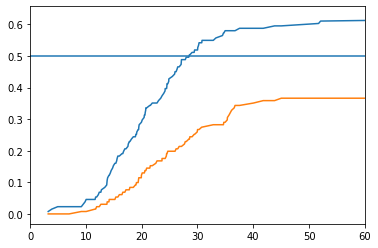

Out of 131 games the Spanish won 82 and lost 48. Out of the concluded games the win rate was 63.0%.


In [ ]:
#@title Pair-of-civilisations matchups (distribution as observed), 1v1 ranked only
# Plot the curve
civ_dataframe.civstring.unique()
first_civ = 'Spanish' #@param {type:"string"} ['Britons', 'Franks', 'Goths', 'Teutons', 'Japanese', 'Chinese','Byzantines', 'Persians', 'Saracens', 'Turks', 'Vikings','Mongols', 'Celts', 'Spanish', 'Aztecs', 'Mayans', 'Huns','Koreans', 'Italians', 'Hindustanis', 'Incas', 'Magyars', 'Slavs','Portuguese', 'Ethiopians', 'Malians', 'Berbers', 'Khmer', 'Malay','Burmese', 'Vietnamese', 'Bulgarians', 'Tatars', 'Cumans','Lithuanians', 'Burgundians', 'Sicilians', 'Poles', 'Bohemians','Dravidians', 'Bengalis', 'Gurjaras', 'Indians'] {allow-input: false}
second_civ = 'Teutons' #@param {type:"string"} ['Britons', 'Franks', 'Goths', 'Teutons', 'Japanese', 'Chinese','Byzantines', 'Persians', 'Saracens', 'Turks', 'Vikings','Mongols', 'Celts', 'Spanish', 'Aztecs', 'Mayans', 'Huns','Koreans', 'Italians', 'Hindustanis', 'Incas', 'Magyars', 'Slavs','Portuguese', 'Ethiopians', 'Malians', 'Berbers', 'Khmer', 'Malay','Burmese', 'Vietnamese', 'Bulgarians', 'Tatars', 'Cumans','Lithuanians', 'Burgundians', 'Sicilians', 'Poles', 'Bohemians','Dravidians', 'Bengalis', 'Gurjaras', 'Indians'] {allow-input: false}

plot_data = outcome_counts_with_totals[(outcome_counts_with_totals['civ1_name'] == first_civ) & (outcome_counts_with_totals['civ2_name'] == second_civ)].copy()
plot_data['minutes'] = plot_data['duration'] / 60
import matplotlib.pyplot as plt
plt.plot(plot_data['minutes'], plot_data['civ1_prop'], label = first_civ+'_wins')
plt.plot(plot_data['minutes'], plot_data['civ2_prop'], label = second_civ+'_wins')
plt.axhline(y=0.5)
plt.xlim((0,60))
plt.show()

print('Out of ' + str(plot_data.matches.max()) + ' games the ' + first_civ + 
      ' won ' + str(plot_data.civ1_won_total.max()) + ' and lost ' + str(plot_data.civ2_won_total.max()) + '. ' +
      'Out of the concluded games the win rate was ' + str((plot_data.civ1_won_total.max() / (plot_data.civ1_won_total.max() + plot_data.civ2_won_total.max()) * 1000) // 1 / 10) + '%.')


In [ ]:
# How about just doing some histograms?

civ_matchup_df_for_histogram = civ_matchup_df.copy()
civ_matchup_df['winning_civ'] = np.where(civ_matchup_df_for_histogram['civ1_won'] == 1, 
                                         civ_matchup_df_for_histogram['civ1_name'],
                                         np.where(civ_matchup_df_for_histogram['civ2_won'] == 1,
                                                  civ_matchup_df_for_histogram['civ2_name'],
                                                  'Neither'))

In [ ]:
import seaborn as sns

#@title Pair-of-civilisations matchups (distribution as observed), 1v1 ranked only
# Plot histograms
civ_dataframe.civstring.unique()
first_civ = 'Spanish' #@param {type:"string"} ['Britons', 'Franks', 'Goths', 'Teutons', 'Japanese', 'Chinese','Byzantines', 'Persians', 'Saracens', 'Turks', 'Vikings','Mongols', 'Celts', 'Spanish', 'Aztecs', 'Mayans', 'Huns','Koreans', 'Italians', 'Hindustanis', 'Incas', 'Magyars', 'Slavs','Portuguese', 'Ethiopians', 'Malians', 'Berbers', 'Khmer', 'Malay','Burmese', 'Vietnamese', 'Bulgarians', 'Tatars', 'Cumans','Lithuanians', 'Burgundians', 'Sicilians', 'Poles', 'Bohemians','Dravidians', 'Bengalis', 'Gurjaras', 'Indians'] {allow-input: false}
second_civ = 'Teutons' #@param {type:"string"} ['Britons', 'Franks', 'Goths', 'Teutons', 'Japanese', 'Chinese','Byzantines', 'Persians', 'Saracens', 'Turks', 'Vikings','Mongols', 'Celts', 'Spanish', 'Aztecs', 'Mayans', 'Huns','Koreans', 'Italians', 'Hindustanis', 'Incas', 'Magyars', 'Slavs','Portuguese', 'Ethiopians', 'Malians', 'Berbers', 'Khmer', 'Malay','Burmese', 'Vietnamese', 'Bulgarians', 'Tatars', 'Cumans','Lithuanians', 'Burgundians', 'Sicilians', 'Poles', 'Bohemians','Dravidians', 'Bengalis', 'Gurjaras', 'Indians'] {allow-input: false}

histogram_data = civ_matchup_df[(civ_matchup_df['civ1_name'] == first_civ) & (civ_matchup_df['civ2_name'] == second_civ)].copy()
histogram_data['minutes'] = histogram_data['duration'] / 60
sns.displot(data=histogram_data, x="minutes", hue="winning_civ", kde=True)



,duration,civ1,civ2,civ1_rating,civ2_rating,civ1_won,civ2_won,civ1_name,civ2_name,winning_civ,minutes
82171,1132.0,14.0,4.0,1456.0,1535.0,0,1,Spanish,Teutons,Teutons,18.866667
82247,1226.0,14.0,4.0,1423.0,1536.0,1,0,Spanish,Teutons,Spanish,20.433333
85901,1471.0,14.0,4.0,1356.0,1385.0,1,0,Spanish,Teutons,Spanish,24.516667
86764,1067.0,14.0,4.0,1367.0,1365.0,1,0,Spanish,Teutons,Spanish,17.783333
87235,1849.0,14.0,4.0,1353.0,1391.0,1,0,Spanish,Teutons,Spanish,30.816667
...,...,...,...,...,...,...,...,...,...,...,...
160645,699.0,14.0,4.0,1326.0,1311.0,0,1,Spanish,Teutons,Teutons,11.650000
160738,1229.0,14.0,4.0,1238.0,1218.0,1,0,Spanish,Teutons,Spanish,20.483333
160949,2139.0,14.0,4.0,1377.0,1389.0,0,1,Spanish,Teutons,Teutons,35.650000
161462,912.0,14.0,4.0,1469.0,1508.0,1,0,Spanish,Teutons,Spanish,15.200000


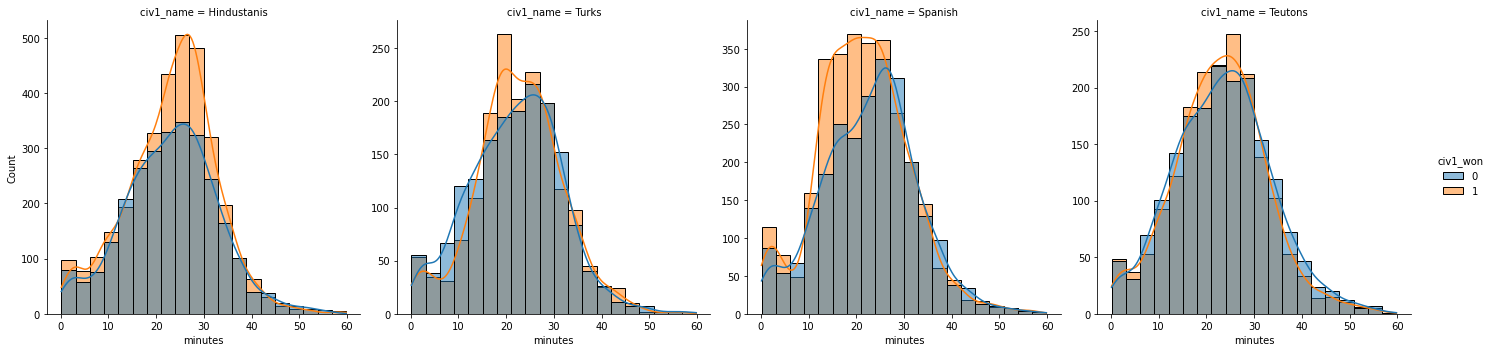

In [ ]:
# Single list of civ histograms

civs_of_interest = ['Spanish', 'Teutons', 'Turks', 'Hindustanis']
histogram_data = civ_matchup_df[civ_matchup_df['civ1_name'].isin(civs_of_interest) & (civ_matchup_df['duration'] < (60 * 60))].copy()
histogram_data['minutes'] = histogram_data['duration'] / 60
sns.displot(data=histogram_data, x="minutes", col = "civ1_name", hue="civ1_won", bins = 20, kde = True, facet_kws = {'sharey': False})
